<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# KNN Classification and Imputation: Cell Phone Churn Data

_Authors: Kiefer Katovich (SF)_

---

In this lab you will practice using KNN for classification (and a little bit for regression as well).

The dataset is one on "churn" in cell phone plans. It has information on the usage of the phones by different account holders and whether or not they churned or not.

Our goal is to predict whether a user will churn or not based on the other features.

We will also be using the KNN model to **impute** missing data. There are a couple of columns in the dataset with missing values, and we can build KNN models to predict what those missing values will most likely be. This is a more advanced imputation method than just filling in the mean or median.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.neighbors import KNeighborsClassifier

### 1. Load the cell phone "churn" data containing some missing values.

In [2]:
churn = pd.read_csv('../data/churn_missing.csv')

### 2. Examine the data. What columns have missing values?

In [4]:
churn.shape

(3333, 20)

In [5]:
churn.dtypes

state              object
account_length      int64
area_code           int64
intl_plan          object
vmail_plan         object
vmail_message     float64
day_mins          float64
day_calls           int64
day_charge        float64
eve_mins          float64
eve_calls           int64
eve_charge        float64
night_mins        float64
night_calls         int64
night_charge      float64
intl_mins         float64
intl_calls          int64
intl_charge       float64
custserv_calls      int64
churn                bool
dtype: object

In [3]:
# A:
churn.isnull().sum()

state               0
account_length      0
area_code           0
intl_plan           0
vmail_plan        400
vmail_message     400
day_mins            0
day_calls           0
day_charge          0
eve_mins            0
eve_calls           0
eve_charge          0
night_mins          0
night_calls         0
night_charge        0
intl_mins           0
intl_calls          0
intl_charge         0
custserv_calls      0
churn               0
dtype: int64

In [6]:
churn.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,KS,128,415,no,yes,25.0,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26.0,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0.0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0.0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0.0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### 3. Convert the `vmail_plan` and `intl_plan` colums to binary integer columns.

Make sure that if a value is missing that you don't fill it in with a new value! Preserve the missing values.

In [8]:
# A:
churn.vmail_plan.value_counts(dropna=False)

no     2130
yes     803
NaN     400
Name: vmail_plan, dtype: int64

In [10]:
churn.intl_plan.value_counts(dropna=False)

no     3010
yes     323
Name: intl_plan, dtype: int64

In [11]:
churn.loc[:,'vmail_plan'] = churn.vmail_plan.map(lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
churn.loc[:,'intl_plan'] = churn.intl_plan.map(lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)b

In [13]:
churn.vmail_plan.value_counts()

0.0    2130
1.0     803
Name: vmail_plan, dtype: int64

### 4. Create dummy coded columns for state and concatenate it to the churn dataset.

> **Remember:** You will need to leave out one of the state dummy coded columns to serve as the "reference" column since we will be using these for modeling.

In [15]:
# A:
states = pd.get_dummies(churn.state, drop_first=True)
states.head()

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
states.shape

(3333, 50)

In [17]:
churn = pd.concat([churn, states], axis=1)

In [19]:
churn.state.shape

(3333,)

### 5. Create a version of the churn data that has no missing values.

Calculate the shape

In [20]:
# A:
churn_nona = churn.dropna()
churn_nona.shape

(2933, 70)

### 6. Create a target vector and predictor matrix.

- Target should be the `churn` column.
- Predictor matrix should be all columns except `area_code`, `state`, and `churn`.

In [23]:
# A:
X = churn_nona.drop(['area_code','state','churn'], axis=1)
y = churn_nona.churn.values

### 7. Calculate the baseline accuracy for `churn`.

In [24]:
# A:
churn_nona.churn.mean()

0.14353903852710534

In [26]:
baseline = 1 - churn_nona.churn.mean()
baseline

0.8564609614728946

### 8. Cross-validate a KNN model predicting `churn`. 

- Number of neighbors should be 5.
- Make sure to standardize the predictor matrix.
- Set cross-validation folds to 10.

Report the mean cross-validated accuracy.

In [30]:
# A:
knn = KNeighborsClassifier(n_neighbors=5)

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [32]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [33]:
scores = cross_val_score(knn, Xs, y, cv=10)
print(scores)
print(np.mean(scores))

[0.84745763 0.86054422 0.86006826 0.85665529 0.87030717 0.85665529
 0.85665529 0.85324232 0.85665529 0.85665529]
0.8574896042757937


### 9. Iterate from k=1 to k=49 (only odd k) and cross-validate the accuracy of the model for each.

Plot the cross-validated mean accuracy for each score. What is the best accuracy?

In [34]:
# A:
# create a list of k values ranging from 1 to 50 every second value
k_values = list(range(1,50,2))
# list to hold score accuracy
accs = []
# loop through the k value list
# set the n_neighour to a k value from the list
# access the cross value score
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xs, y, cv=10)
    accs.append(np.mean(scores))

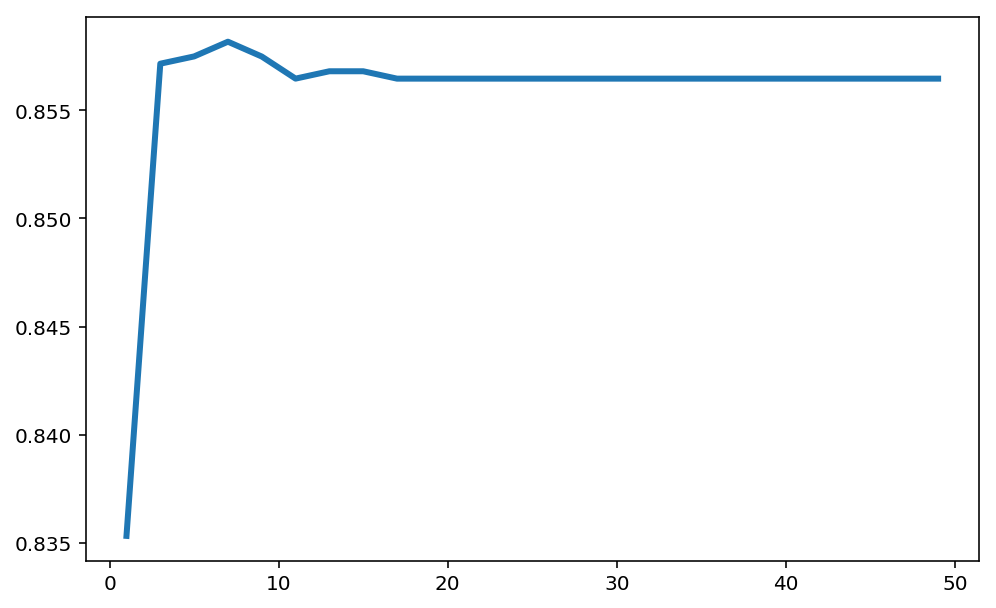

0.8581698921253003


In [35]:
# plot the result
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(k_values, accs, lw=3)
plt.show()

print(np.max(accs))

### 10. Imputing with KNN

K-Nearest Neighbors can be used to impute missing values in datasets. What we will do is estimate the most likely value for the missing data based on a KNN model.

We have two columns with missing data:
- `vmail_plan`
- `vmail_message`

**10.A Create two subsets of the churn dataset: one without missing values for `vmail_plan` and `vmail_message`, and one with the missing values.**

In [11]:
# A:

First we will impute values for `vmail_plan`. This is a categorical column and so we will impute using classification (predicting whether the plan is yes or no, 1 vs. 0).

**10.B Create a target that is `vmail_plan` and predictor matrix that is all columns except `state`, `area_code`, `churn`, `vmail_plan`, and `vmail_message`.**

> **Note:** We don't include the `churn` variable in the model to impute. Why? We are imputing these missing values so that we can use the rows to predict churn with more data afterwards. If we imputed with churn as a predictor then we would be cheating.

In [12]:
# A:

**10.C Standardize the predictor matrix.**

In [13]:
# A:

**10.D Find the best K for predicting `vmail_plan`.**

You may want to write a function for this. What is the accuracy for predicting `vmail_plan` at the best K? What is the baseline accuracy for `vmail_plan`?

In [14]:
# A:

**10.E Fit a `KNeighborsClassifier` with the best number of neighbors.**

In [15]:
# A:

**10.F Predict the missing `vmail_plan` values using the subset of the data where it is misssing.**

You will need to:
1. Create a new predictor matrix using the same predictors but from the missing subset of data.
- Standardize this predictor matrix *using the StandardScaler object fit on the non-missing data*. This means you will just use the `.transform()` function. It is important to standardize the new predictors the same way we standardized the original predictors if we want the predictions to make sense. Calling `.fit_transform()` will reset the standardized scale.
- Predict what the missing vmail plan values should be.
- Replace the missing values in the original with the predicted values.

> **Note:** It may predict all 0's. This is OK. If you want to see the predicted probabilities of `vmail_plan` for each row you can use the `.predict_proba()` function instead of `.predict()`.  You can use these probabilities to manually set the criteria threshold.

In [16]:
# A:

### 11. Impute the missing values for `vmail_message` using the same process.

Since `vmail_message` is essentially a continuous measure, you need to use `KNeighborsRegressor` instead of the `KNeighborsClassifier`.

KNN can do both regression and classification! Instead of "voting" on the class like in classification, the neighbors will average their value for the target in regression.

In [17]:
# A:

### 12. Given the accuracy (and $R^2$) of your best imputation models when finding the best K neighbors, do you think imputing is a good idea?

In [18]:
# A:

### 13. With the imputed dataset, cross-validate the accuracy predicting churn. Is it better? Worse? The same?

In [19]:
# A: